In [1]:
from glob import glob
import pandas as pd
from matplotlib_venn import venn2_unweighted, venn3, venn3_circles, venn3_unweighted
import matplotlib.pyplot as plt
import seaborn as sns

primary = '#33B9CB'
secondary = '#6A994E'
tertiary = '#F5911F'

OUT_DIR = '../../02-OUTPUT/06-ANALYSIS'
optimized_df = pd.read_csv(f'{OUT_DIR}/tss_df.csv').query('dataset == "optimized"')
ortho_df = pd.read_csv('../../02-OUTPUT/05-PIRATE/orthologous_clustering.csv')[['BV1','BV2','BV3','consensus_product']]

ops_df = optimized_df.query('TSS_class == "primary" or TSS_class == "secondary"')
tmp = ops_df.drop_duplicates(subset=['contig','TSS_position','TSS_strand']).groupby(['biovar','TSS_locus_tag']).count().reset_index()
multi_tss_df = pd.concat([
    tmp[['biovar','TSS_locus_tag','contig']].query('biovar == "BV1"').merge(ortho_df[['BV1','BV2','BV3','consensus_product']],left_on=['TSS_locus_tag'],right_on=['BV1']),
    tmp[['biovar','TSS_locus_tag','contig']].query('biovar == "BV2"').merge(ortho_df[['BV1','BV2','BV3','consensus_product']],left_on=['TSS_locus_tag'],right_on=['BV2']),
    tmp[['biovar','TSS_locus_tag','contig']].query('biovar == "BV3"').merge(ortho_df[['BV1','BV2','BV3','consensus_product']],left_on=['TSS_locus_tag'],right_on=['BV3'])]).reset_index(drop=True)
multi_tss_df = multi_tss_df.rename(columns={'TSS_locus_tag':'locus_tag','contig':'ops_count'})
multi_tss_df = multi_tss_df.query('ops_count >= 2').reset_index(drop=True)

multi_tss_df['in_BV1'] = None
multi_tss_df['in_BV2'] = None
multi_tss_df['in_BV3'] = None
multi_tss_df['in_BV1_BV2'] = None
multi_tss_df['in_BV2_BV3'] = None
multi_tss_df['in_BV1_BV3'] = None
multi_tss_df['in_BV1_BV2_BV3'] = None
bv1_query = multi_tss_df.query('biovar == "BV1"')['BV1'].to_list()
bv2_query = multi_tss_df.query('biovar == "BV2"')['BV1'].to_list()
bv3_query = multi_tss_df.query('biovar == "BV3"')['BV1'].to_list()
for idx, row in multi_tss_df.iterrows():
    multi_tss_df.loc[idx, 'in_BV1'] = row['BV1'] in bv1_query
    multi_tss_df.loc[idx, 'in_BV2'] = row['BV1'] in bv2_query
    multi_tss_df.loc[idx, 'in_BV3'] = row['BV1'] in bv3_query
    multi_tss_df.loc[idx, 'in_BV1_BV2'] = row['BV1'] in bv1_query and row['BV1'] in bv2_query
    multi_tss_df.loc[idx, 'in_BV1_BV3'] = row['BV1'] in bv1_query and row['BV1'] in bv3_query
    multi_tss_df.loc[idx, 'in_BV2_BV3'] = row['BV1'] in bv2_query and row['BV1'] in bv3_query
    multi_tss_df.loc[idx, 'in_BV1_BV2_BV3'] = row['BV1'] in bv1_query and row['BV1'] in bv2_query and row['BV1'] in bv3_query
multi_tss_df = multi_tss_df.drop(columns=['locus_tag']).rename(columns={'biovar':'biovar_dataset','contig':'primary_secondary_TSS_count'}).reset_index(drop=True)
multi_tss_df = multi_tss_df.drop_duplicates('BV1')

ops_df = optimized_df.query('TSS_class == "primary" or TSS_class == "secondary"').copy()
tmp = ops_df.query('biovar == "BV1" and TSS_locus_tag != "orphan"').groupby('TSS_locus_tag').agg({'UTR_length': lambda x: x.tolist(),  }).reset_index().rename(columns={'UTR_length':'BV1_distance'})
utr_df = multi_tss_df.merge(tmp, left_on='BV1', right_on='TSS_locus_tag',how='outer').drop(columns=['TSS_locus_tag'])
tmp = ops_df.query('biovar == "BV2"').groupby('TSS_locus_tag').agg({'UTR_length': lambda x: x.tolist(),  }).reset_index().rename(columns={'UTR_length':'BV2_distance'})
utr_df = utr_df.merge(tmp, left_on='BV2', right_on='TSS_locus_tag',how='outer').drop(columns='TSS_locus_tag')
tmp = ops_df.query('biovar == "BV3"').groupby('TSS_locus_tag').agg({'UTR_length': lambda x: x.tolist(),  }).reset_index().rename(columns={'UTR_length':'BV3_distance'})
utr_df = utr_df.merge(tmp, left_on='BV3', right_on='TSS_locus_tag',how='outer').drop(columns='TSS_locus_tag')
utr_df = utr_df.dropna(subset=['biovar_dataset'])
utr_df = utr_df.fillna(0)
multi_tss_df = utr_df.copy()
multi_tss_df
# o['BV1_ortholog'] = o['BV1'].replace(dict(zip(y['BV2'],y['BV1']))).replace(dict(zip(y['BV3'],y['BV1'])))
# query = multi_tss_df.query('in_BV1_BV2 == True or in_BV1_BV3 == True or in_BV2_BV3 == True')['BV1'].to_list()

,biovar_dataset,ops_count,BV1,BV2,BV3,consensus_product,in_BV1,in_BV2,in_BV3,in_BV1_BV2,in_BV2_BV3,in_BV1_BV3,in_BV1_BV2_BV3,BV1_distance,BV2_distance,BV3_distance
0,BV1,2.0,Atu0029,MDIPDJ_16845,FLNPIO_16765,adenosylhomocysteinase,True,False,False,False,False,False,False,"[51.0, 84.0]",[91.0],[94.0]
1,BV1,2.0,Atu0201,MDIPDJ_01480,FLNPIO_01605,iron-responsive transcriptional regulator RirA,True,False,False,False,False,False,False,"[21.0, 145.0]",[37.0],[77.0]
2,BV1,2.0,Atu0254,MDIPDJ_18605,FLNPIO_17415,translation initiation factor IF-3,True,False,False,False,False,False,False,"[209.0, 200.0]",[222.0],[190.0]
3,BV1,2.0,Atu0331,MDIPDJ_00065,FLNPIO_00055,ribosome-associated translation inhibitor RaiA,True,True,False,True,False,False,False,"[28.0, 156.0]","[29.0, 53.0, 160.0]",[27.0]
4,BV1,2.0,Atu0359,MDIPDJ_00235,FLNPIO_00195,HlyC/CorC family transporter,True,False,False,False,False,False,False,"[158.0, 38.0]",[112.0],[109.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,BV3,2.0,Atu0046,MDIPDJ_16940,FLNPIO_16675,DUF1402 family protein,False,False,True,False,False,False,False,0,0,"[101.0, 124.0]"
140,BV3,2.0,Atu0034,MDIPDJ_16870,FLNPIO_16740,response regulator transcription factor,False,False,True,False,False,False,False,[73.0],[76.0],"[96.0, 85.0]"
141,BV3,2.0,Atu0048,MDIPDJ_16960,FLNPIO_16800,L%2CD-transpeptidase,False,False,True,False,False,False,False,[54.0],[117.0],"[52.0, 112.0]"
142,BV3,2.0,Atu0135,MDIPDJ_18250,FLNPIO_17555,uracil phosphoribosyltransferase,False,False,True,False,False,False,False,0,[30.0],"[220.0, 38.0]"


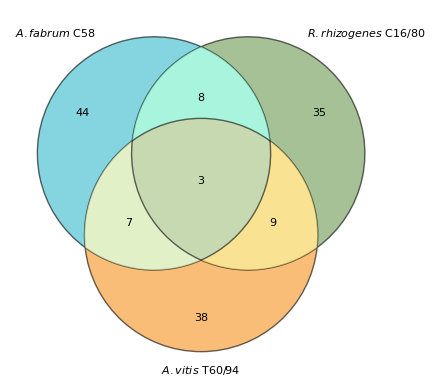

In [2]:
bv1 = set(bv1_query)
bv2 = set(bv2_query)
bv3 = set(bv3_query)
v = venn3_unweighted(subsets=(bv1,bv2,bv3), set_labels=(r'$\it{A. fabrum}$ C58', r'$\it{R. rhizogenes}$ C16/80', r'$\it{A. vitis}$ T60/94'),set_colors=[primary,secondary,tertiary],alpha=0.6)
for i in range(len(v.patches)):
    if i in [0,1,3,6,7]:
        patch = v.patches[i]
        patch.set_edgecolor("black")
        patch.set_lw(1)
for text in v.set_labels:
    text.set_fontsize(8)
for x in range(len(v.subset_labels)):
    if v.subset_labels[x] is not None:
        v.subset_labels[x].set_fontsize(8)
plt.savefig('tmp.png',dpi=300,bbox_inches='tight')

In [3]:
# query = multi_tss_df['BV1'].to_list() + multi_tss_df['BV2'].to_list() + multi_tss_df['BV3'].to_list()
# test = optimized_df[optimized_df['TSS_locus_tag'].isin(query)].drop_duplicates(subset=['TSS_locus_tag','TSS_promoter','contig','biovar','TSS_position'])
# with open('tss_promoters.fna','w') as file:
#     for idx, row in test.iterrows():
#         file.write(f'>{row["biovar"]}|{row["contig"]}|{row["TSS_locus_tag"]}|{row["TSS_position"]}\n{row["TSS_promoter"]}\n')

# from Bio.Seq import Seq
# fna_df = pd.read_csv('../../02-OUTPUT/06-ANALYSIS/table1.csv').rename(columns={'name':'contig'})

# gff_df = pd.read_csv(f'{OUT_DIR}/all_gff_df.csv')
# test = gff_df[gff_df['ID'].isin(query)].copy().reset_index(drop=True)
# def get_promoter(row, promoter_len = 51):
#     seq = fna_df.query(f'biovar == "{row["biovar"]}" and contig == "{row["seq_id"]}"')['sequence'].item()
#     if row['strand'] == '+':
#         start = int(row['start']) - 1 - promoter_len
#         end = int(row['start']) - 1
#     else:
#         start = int(row['end'])
#         end = int(row['end']) + promoter_len
#     promoter = ''.join(Seq(seq)[start:end])

#     if len(promoter) == promoter_len:
#         return promoter
#     else:
#         raise Exception('promoter not correct length')
# test['promoter'] = test.apply(lambda row: get_promoter(row,300),axis=1)

# with open('gff_promoters.fna','w') as file:
#     for idx, row in test.iterrows():
#         file.write(f'>{row["biovar"]}|{row["seq_id"]}|{row["ID"]}\n{row["promoter"]}\n')

motif_df = None
for path in glob("../../04-OTHER/04-MISC/*.tsv"):
    df = pd.read_csv(path,sep='\t').dropna(subset=['matched_sequence']).drop(columns=['motif_id','motif_alt_id'])
    df['motif'] = path.split('/')[-1].replace('_hits.tsv','')
    motif_df = pd.concat([motif_df, df]).reset_index(drop=True)
motif_df[['biovar', 'contig', 'locus_tag']] = motif_df['sequence_name'].str.split('|', 2, expand=True)
motif_df = motif_df.rename(columns={'start':'gene_start','stop':'gene_stop'}).drop(columns=['sequence_name'])
bv2_bv1 = dict(zip(ortho_df['BV2'],ortho_df['BV1']))
bv3_bv1 = dict(zip(ortho_df['BV3'],ortho_df['BV1']))
motif_df['BV1_locus_tag'] = motif_df['locus_tag'].replace(bv2_bv1).replace(bv3_bv1)
motif_df['range'] = motif_df[['gene_start', 'gene_stop']].apply(tuple, axis=1)
motif_df


,gene_start,gene_stop,strand,score,p-value,q-value,matched_sequence,motif,biovar,contig,locus_tag,BV1_locus_tag,range
0,179.0,193.0,-,12.0641,0.000001,0.259,TTAACCCTGTGTTGA,ctrA_half_act,BV1,NC_003062.2,Atu1392,Atu1392,"(179.0, 193.0)"
1,222.0,236.0,-,11.4872,0.000004,0.259,TTAACGCTTCCTTGC,ctrA_half_act,BV2,chromosome,MDIPDJ_12290,Atu3777,"(222.0, 236.0)"
2,161.0,175.0,+,11.3974,0.000005,0.259,TTAACCCTTTCTTAA,ctrA_half_act,BV2,chromosome,MDIPDJ_11990,Atu3742,"(161.0, 175.0)"
3,170.0,184.0,+,11.3974,0.000005,0.259,TTAACCCTTTCTTAA,ctrA_half_act,BV3,chromosome,FLNPIO_12930,Atu3742,"(170.0, 184.0)"
4,213.0,227.0,-,11.2179,0.000007,0.259,TTAACCCCCGGGTAA,ctrA_half_act,BV3,chromosome,FLNPIO_13075,Atu3763,"(213.0, 227.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,239.0,245.0,+,10.8427,0.000097,0.456,GCGACAA,sciP_half,BV3,chromosome,FLNPIO_10065,Atu2092,"(239.0, 245.0)"
271,236.0,242.0,-,10.8427,0.000097,0.456,GCGACAA,sciP_half,BV3,chromosome,FLNPIO_06965,Atu1839,"(236.0, 242.0)"
272,246.0,252.0,-,10.8427,0.000097,0.456,GCGACAA,sciP_half,BV3,chromosome,FLNPIO_00115,Atu0344,"(246.0, 252.0)"
273,249.0,255.0,-,10.8427,0.000097,0.456,GCGACAA,sciP_half,BV2,chromosome,MDIPDJ_07425,Atu1842,"(249.0, 255.0)"


In [4]:
hits = [1164,3742,2434,3631,1710,2103,2121,3883,4215,2086]
hits = ['Atu' + str(hit) for hit in hits]
hits_df = multi_tss_df[ multi_tss_df['BV1'].isin(hits) ].sort_values('BV1').copy()

tmp = motif_df.query('biovar == "BV1"').groupby(['biovar','locus_tag']).agg({'motif': lambda x: x.tolist()}).reset_index().rename(columns={'motif':'BV1_motifs'})
utr_df = hits_df.merge(tmp, left_on='BV1', right_on='locus_tag',how='outer').drop(columns=['locus_tag','biovar'])
tmp = motif_df.query('biovar == "BV2"').groupby(['biovar','locus_tag']).agg({'motif': lambda x: x.tolist()}).reset_index().rename(columns={'motif':'BV2_motifs'})
utr_df = utr_df.merge(tmp, left_on='BV2', right_on='locus_tag',how='outer').drop(columns=['locus_tag','biovar'])
tmp = motif_df.query('biovar == "BV3"').groupby(['biovar','locus_tag']).agg({'motif': lambda x: x.tolist()}).reset_index().rename(columns={'motif':'BV3_motifs'})
utr_df = utr_df.merge(tmp, left_on='BV3', right_on='locus_tag',how='outer').drop(columns=['locus_tag','biovar'])
utr_df = utr_df.dropna(subset=['biovar_dataset'])
utr_df = utr_df.fillna(0)
hits_df = utr_df
hits_df

,biovar_dataset,ops_count,BV1,BV2,BV3,consensus_product,in_BV1,in_BV2,in_BV3,in_BV1_BV2,in_BV2_BV3,in_BV1_BV3,in_BV1_BV2_BV3,BV1_distance,BV2_distance,BV3_distance,BV1_motifs,BV2_motifs,BV3_motifs
0,BV1,2.0,Atu1164,MDIPDJ_04320,FLNPIO_04565,murein L%2CD-transpeptidase,True,True,True,True,True,True,True,"[175.0, 31.0]","[282.0, 262.0, 169.0, 51.0]","[237.0, 122.0]",[sciP_full],[sciP_full],0
1,BV2,3.0,Atu1710,MDIPDJ_05775,FLNPIO_08915,SPOR domain-containing protein,False,True,True,False,True,False,False,[159.0],"[283.0, 155.0, 23.0]","[25.0, 160.0]",0,0,[sciP_half]
2,BV2,2.0,Atu2086,MDIPDJ_24390,FLNPIO_10035,cell division protein FtsZ,False,True,True,False,True,False,False,[45.0],"[97.0, 85.0]",0,"[sciP_full, sciP_full, sciP_full]",[sciP_half],"[sciP_full, sciP_full, sciP_half]"
3,BV2,2.0,Atu4215,MDIPDJ_24390,FLNPIO_10035,cell division protein FtsZ,False,True,True,False,True,False,False,0,"[97.0, 85.0]",0,0,[sciP_half],"[sciP_full, sciP_full, sciP_half]"
4,BV2,2.0,Atu2103,MDIPDJ_09105,FLNPIO_10120,transcriptional regulator MraZ,False,True,True,False,True,False,False,[171.0],"[141.0, 209.0]","[171.0, 240.0]",[ctrA_full],0,0
5,BV2,2.0,Atu2121,MDIPDJ_09165,FLNPIO_10180,glycoside hydrolase,False,True,True,False,True,False,False,0,"[121.0, 113.0]","[132.0, 121.0]",0,0,0
6,BV1,2.0,Atu2434,MDIPDJ_11185,FLNPIO_12070,response regulator transcription factor,True,True,False,True,False,False,False,"[290.0, 84.0]","[288.0, 82.0]",[84.0],"[ctrA_half_act, ctrA_full]",0,"[ctrA_half_act, ctrA_full]"
7,BV1,2.0,Atu3631,MDIPDJ_13920,FLNPIO_15055,hypothetical protein,True,False,True,False,False,True,False,"[286.0, 215.0]",[150.0],"[263.0, 135.0]",0,0,[ctrA_full]
8,BV1,2.0,Atu3742,MDIPDJ_11990,FLNPIO_12930,DUF1465 family protein,True,True,True,True,True,True,True,"[263.0, 73.0]","[278.0, 91.0, 82.0]","[81.0, 73.0]","[ctrA_half_act, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]"
9,BV2,2.0,Atu3883,MDIPDJ_12390,FLNPIO_13245,response regulator,False,True,True,False,True,False,False,0,"[207.0, 39.0]","[142.0, 115.0]",0,[ctrA_half_act],0


In [5]:
tmp = motif_df.query('biovar == "BV1"').groupby(['biovar','locus_tag']).agg({'motif': lambda x: x.tolist()}).reset_index().rename(columns={'motif':'BV1_motifs'})
utr_df = hits_df.merge(tmp, left_on='BV1', right_on='locus_tag',how='outer').drop(columns=['locus_tag','biovar'])
tmp = motif_df.query('biovar == "BV2"').groupby(['biovar','locus_tag']).agg({'motif': lambda x: x.tolist()}).reset_index().rename(columns={'motif':'BV2_motifs'})
utr_df = utr_df.merge(tmp, left_on='BV2', right_on='locus_tag',how='outer').drop(columns=['locus_tag','biovar'])
tmp = motif_df.query('biovar == "BV3"').groupby(['biovar','locus_tag']).agg({'motif': lambda x: x.tolist()}).reset_index().rename(columns={'motif':'BV3_motifs'})
utr_df = utr_df.merge(tmp, left_on='BV3', right_on='locus_tag',how='outer').drop(columns=['locus_tag','biovar'])
utr_df = utr_df.dropna(subset=['biovar_dataset'])
utr_df = utr_df.fillna(0)
hits_df = utr_df
hits_df

,biovar_dataset,ops_count,BV1,BV2,BV3,consensus_product,in_BV1,in_BV2,in_BV3,in_BV1_BV2,...,in_BV1_BV2_BV3,BV1_distance,BV2_distance,BV3_distance,BV1_motifs_x,BV2_motifs_x,BV3_motifs_x,BV1_motifs_y,BV2_motifs_y,BV3_motifs_y
0,BV1,2.0,Atu1164,MDIPDJ_04320,FLNPIO_04565,murein L%2CD-transpeptidase,True,True,True,True,...,True,"[175.0, 31.0]","[282.0, 262.0, 169.0, 51.0]","[237.0, 122.0]",[sciP_full],[sciP_full],0,[sciP_full],[sciP_full],0
1,BV2,3.0,Atu1710,MDIPDJ_05775,FLNPIO_08915,SPOR domain-containing protein,False,True,True,False,...,False,[159.0],"[283.0, 155.0, 23.0]","[25.0, 160.0]",0,0,[sciP_half],0,0,[sciP_half]
2,BV2,2.0,Atu2086,MDIPDJ_24390,FLNPIO_10035,cell division protein FtsZ,False,True,True,False,...,False,[45.0],"[97.0, 85.0]",0,"[sciP_full, sciP_full, sciP_full]",[sciP_half],"[sciP_full, sciP_full, sciP_half]","[sciP_full, sciP_full, sciP_full]",[sciP_half],"[sciP_full, sciP_full, sciP_half]"
3,BV2,2.0,Atu4215,MDIPDJ_24390,FLNPIO_10035,cell division protein FtsZ,False,True,True,False,...,False,0,"[97.0, 85.0]",0,0,[sciP_half],"[sciP_full, sciP_full, sciP_half]",0,[sciP_half],"[sciP_full, sciP_full, sciP_half]"
4,BV2,2.0,Atu2103,MDIPDJ_09105,FLNPIO_10120,transcriptional regulator MraZ,False,True,True,False,...,False,[171.0],"[141.0, 209.0]","[171.0, 240.0]",[ctrA_full],0,0,[ctrA_full],0,0
5,BV2,2.0,Atu2121,MDIPDJ_09165,FLNPIO_10180,glycoside hydrolase,False,True,True,False,...,False,0,"[121.0, 113.0]","[132.0, 121.0]",0,0,0,0,0,0
6,BV1,2.0,Atu2434,MDIPDJ_11185,FLNPIO_12070,response regulator transcription factor,True,True,False,True,...,False,"[290.0, 84.0]","[288.0, 82.0]",[84.0],"[ctrA_half_act, ctrA_full]",0,"[ctrA_half_act, ctrA_full]","[ctrA_half_act, ctrA_full]",0,"[ctrA_half_act, ctrA_full]"
7,BV1,2.0,Atu3631,MDIPDJ_13920,FLNPIO_15055,hypothetical protein,True,False,True,False,...,False,"[286.0, 215.0]",[150.0],"[263.0, 135.0]",0,0,[ctrA_full],0,0,[ctrA_full]
8,BV1,2.0,Atu3742,MDIPDJ_11990,FLNPIO_12930,DUF1465 family protein,True,True,True,True,...,True,"[263.0, 73.0]","[278.0, 91.0, 82.0]","[81.0, 73.0]","[ctrA_half_act, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]","[ctrA_half_act, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]"
9,BV2,2.0,Atu3883,MDIPDJ_12390,FLNPIO_13245,response regulator,False,True,True,False,...,False,0,"[207.0, 39.0]","[142.0, 115.0]",0,[ctrA_half_act],0,0,[ctrA_half_act],0


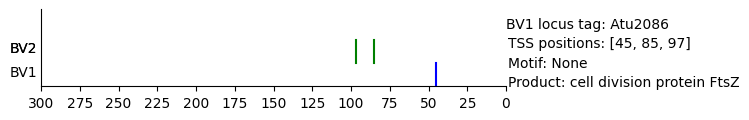

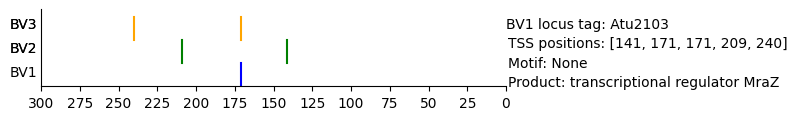

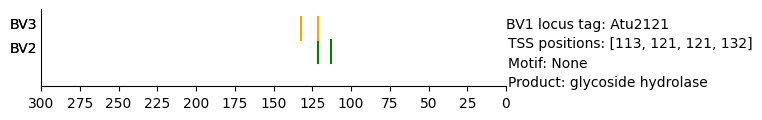

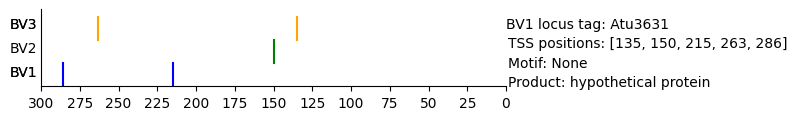

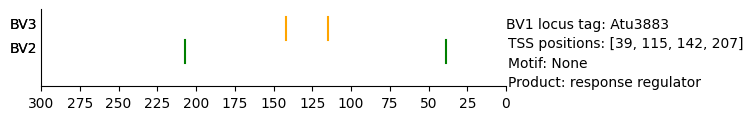

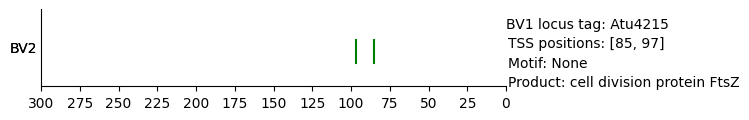

In [13]:
def plot_distances(row, motif_filter):
    fig, ax = plt.subplots(figsize = (6, 1))
    distance_str = []
    tmp = motif_df.query(f'motif == "{motif_filter}"')

    query = tmp.query(f'BV1_locus_tag == "{row["BV1"]}" and biovar == "BV1"')
    if row['BV1_distance'] != 0:
        for distance in row['BV1_distance']:
            ax.axvline(x=distance, ymin=0, ymax=0.3, color='blue')
            ax.text(x=320,y=0.5,s='BV1')
        distance_str += row['BV1_distance']
        if len(query) > 0:
            for _,r in query.iterrows():
                start, end = r['range']
                rect = plt.Rectangle((start,0),end-start,1.2,linewidth=1, edgecolor='black', facecolor='r', label='')
                ax.add_patch(rect)

    query = tmp.query(f'BV1_locus_tag == "{row["BV1"]}" and biovar == "BV2"')
    if row['BV2_distance'] != 0:
        for distance in row['BV2_distance']:
                ax.axvline(x = distance, ymin=0.3, ymax=0.6,color = 'green')
                ax.text(x=320,y=1.75,s='BV2')
        distance_str += row['BV2_distance']
        if len(query) > 0:
            for _,r in query.iterrows():
                start, end = r['range']
                rect = plt.Rectangle((start,1.2),end-start,1.2,linewidth=1, edgecolor='black', facecolor='r', label='')
                ax.add_patch(rect)

    query = tmp.query(f'BV1_locus_tag == "{row["BV1"]}" and biovar == "BV3"')
    if row['BV3_distance'] != 0:
        for distance in row['BV3_distance']:
                ax.axvline(x = distance, ymin=0.6, ymax=0.9, color = 'orange')
                ax.text(x=320,y=3,s='BV3')
        distance_str += row['BV3_distance']
        if len(query) > 0:
            for _,r in query.iterrows():
                start, end = r['range']
                rect = plt.Rectangle((start,2.4),end-start,1.2,linewidth=1, edgecolor='black', facecolor='r', label='')
                ax.add_patch(rect)

    ax.text(x=0,y=3,s='BV1 locus tag: ' + str(row['BV1']))
    ax.text(x=-1,y=2,s='TSS positions: ' + str(sorted([int(d) for d in distance_str])))
    ax.text(x=-1,y=1,s='Motif: ' + motif_filter)
    ax.text(x=-1,y=0,s='Product: ' + str(row['consensus_product']))


    # query = motif_df.query(f'BV1_locus_tag == "{row["BV1"]}" and biovar == "BV2"')
    # query = motif_df.query(f'BV1_locus_tag == "{row["BV1"]}" and biovar == "BV3"')

    # display(query, len(query))
    # try:
    #     distance_str = row['BV1_distance'] + row['BV2_distance'] + row['BV3_distance']
    #     distance_str = sorted([int(d) for d in distance_str])
    #     plt.text(x=-1,y=-1,s=distance_str)
    # except:
    #     print('null found', row['biovar_dataset'], row['BV1'])  

    plt.ylim([0,4])
    plt.xlim([0,300])
    plt.xticks(range(0,325,25))
    plt.yticks([])
    plt.gca().invert_xaxis()
    sns.despine(top=True, right=True, left=False, bottom=False)
    # plt.savefig(f"{row['BV1']}_{motif_filter}_plot.svg",bbox_inches='tight')

# atu = 'Atu3742'
# for motif in motif_df.query(f'BV1_locus_tag == "{atu}"').motif.unique():
    # hits_df.query(f'BV1 == "{atu}"').apply(lambda row: plot_distances(row, motif_filter=motif), axis=1);
# hits_df.query('BV1 == "Atu3742"').apply(lambda row: plot_distances(row, motif_filter='ctrA_full'), axis=1);
# hits_df.apply(lambda row: plot_distances(row, motif_filter='ctrA_full'), axis=1);
hits_df[~hits_df['BV1'].isin(['Atu1164','Atu2434','Atu3742','Atu1710'])].sort_values('BV1').apply(lambda row: plot_distances(row, motif_filter='None'), axis=1);


In [12]:
hits_df

,biovar_dataset,ops_count,BV1,BV2,BV3,consensus_product,in_BV1,in_BV2,in_BV3,in_BV1_BV2,...,in_BV1_BV2_BV3,BV1_distance,BV2_distance,BV3_distance,BV1_motifs_x,BV2_motifs_x,BV3_motifs_x,BV1_motifs_y,BV2_motifs_y,BV3_motifs_y
0,BV1,2.0,Atu1164,MDIPDJ_04320,FLNPIO_04565,murein L%2CD-transpeptidase,True,True,True,True,...,True,"[175.0, 31.0]","[282.0, 262.0, 169.0, 51.0]","[237.0, 122.0]",[sciP_full],[sciP_full],0,[sciP_full],[sciP_full],0
1,BV2,3.0,Atu1710,MDIPDJ_05775,FLNPIO_08915,SPOR domain-containing protein,False,True,True,False,...,False,[159.0],"[283.0, 155.0, 23.0]","[25.0, 160.0]",0,0,[sciP_half],0,0,[sciP_half]
2,BV2,2.0,Atu2086,MDIPDJ_24390,FLNPIO_10035,cell division protein FtsZ,False,True,True,False,...,False,[45.0],"[97.0, 85.0]",0,"[sciP_full, sciP_full, sciP_full]",[sciP_half],"[sciP_full, sciP_full, sciP_half]","[sciP_full, sciP_full, sciP_full]",[sciP_half],"[sciP_full, sciP_full, sciP_half]"
3,BV2,2.0,Atu4215,MDIPDJ_24390,FLNPIO_10035,cell division protein FtsZ,False,True,True,False,...,False,0,"[97.0, 85.0]",0,0,[sciP_half],"[sciP_full, sciP_full, sciP_half]",0,[sciP_half],"[sciP_full, sciP_full, sciP_half]"
4,BV2,2.0,Atu2103,MDIPDJ_09105,FLNPIO_10120,transcriptional regulator MraZ,False,True,True,False,...,False,[171.0],"[141.0, 209.0]","[171.0, 240.0]",[ctrA_full],0,0,[ctrA_full],0,0
5,BV2,2.0,Atu2121,MDIPDJ_09165,FLNPIO_10180,glycoside hydrolase,False,True,True,False,...,False,0,"[121.0, 113.0]","[132.0, 121.0]",0,0,0,0,0,0
6,BV1,2.0,Atu2434,MDIPDJ_11185,FLNPIO_12070,response regulator transcription factor,True,True,False,True,...,False,"[290.0, 84.0]","[288.0, 82.0]",[84.0],"[ctrA_half_act, ctrA_full]",0,"[ctrA_half_act, ctrA_full]","[ctrA_half_act, ctrA_full]",0,"[ctrA_half_act, ctrA_full]"
7,BV1,2.0,Atu3631,MDIPDJ_13920,FLNPIO_15055,hypothetical protein,True,False,True,False,...,False,"[286.0, 215.0]",[150.0],"[263.0, 135.0]",0,0,[ctrA_full],0,0,[ctrA_full]
8,BV1,2.0,Atu3742,MDIPDJ_11990,FLNPIO_12930,DUF1465 family protein,True,True,True,True,...,True,"[263.0, 73.0]","[278.0, 91.0, 82.0]","[81.0, 73.0]","[ctrA_half_act, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]","[ctrA_half_act, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]","[ctrA_half_act, ctrA_full, ctrA_full]"
9,BV2,2.0,Atu3883,MDIPDJ_12390,FLNPIO_13245,response regulator,False,True,True,False,...,False,0,"[207.0, 39.0]","[142.0, 115.0]",0,[ctrA_half_act],0,0,[ctrA_half_act],0


In [11]:
# hits_df[hits_df['BV1'].isin(['Atu1164'])].apply(lambda row: plot_distances(row, motif_filter='sciP_full'), axis=1);
# hits_df[hits_df['BV1'].isin(['Atu2434','Atu3742','Atu1710'])].apply(lambda row: plot_distances(row, motif_filter='ctrA_full'), axis=1);